## Baseflow Separation with Recursive Digital Filters

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-streamgage/blob/main/Stream%20Gage%20Ex.%206%20-%20Baseflow%20Separation.ipynb)

In [1]:
# colab uses python 3.7.15 currently and has no zoneinfo
# from zoneinfo import ZoneInfo

from datetime import datetime
import pytz
from math import ceil, floor,fmod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    path = 'https://github.com/mrahnis/nb-streamgage/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [3]:
gages = {'01576516':'east branch',
         '015765185':'west branch',
         '015765195':'mainstem'}

gage = '015765195'
freq = 'daily' # daily or instantaneous
col = '00060_Mean'

for key in gages:
    print('https://waterdata.usgs.gov/monitoring-location/{}/'.format(key))

https://waterdata.usgs.gov/monitoring-location/01576516/
https://waterdata.usgs.gov/monitoring-location/015765185/
https://waterdata.usgs.gov/monitoring-location/015765195/


In [4]:
# load data
df_all = pd.read_parquet('{}/data/nwis_{}_{}_all.parquet{}'.format(path, gage, freq, params))

# let's examine a subset of the data to see what happens up close
# startdate = datetime(2012, 1, 1, 0, 0, tzinfo=ZoneInfo("US/Eastern"))
# enddate = datetime(2012, 12, 31, 0, 0, tzinfo=ZoneInfo("US/Eastern"))
startdate = datetime(2012, 1, 1, 0, 0, tzinfo=pytz.timezone('US/Eastern'))
enddate = datetime(2012, 1, 31, 0, 0, tzinfo=pytz.timezone('US/Eastern'))

df = df_all[startdate:enddate].copy()
Q = df[col].to_numpy()
# Q = df_all[col].to_numpy()


## One-Parameter Recursive Digital Filter of Nathan and McMahon, 1990

$\large R_{t} = \alpha \cdot R_{(t- \Delta t)} + \frac{1 + \alpha}{2} \cdot (Q_{t}-Q_{(t- \Delta t)})$

where:
- $\alpha$ is an adjustable filter parameter usually between 0.9 and 0.95
- $R_{t}$ is the calculated runoff or quickflow component of discharge at time t
- $Q_{t}$ is the observed total discharge at time t
- $Q_{(t- \Delta t)}$ is the observed total discharge one timestep prior to time t

and baseflow:
- $Q_{b_{t}} = Q_{t}-R_{t}$

In [5]:
alpha = 0.9           # parameter, alpha
R = np.zeros_like(Q)  # initialize R to zeros

In [6]:
# usually iterate 1, 2, or 3 times
n = 3

for i in range(n):
    R = alpha*np.roll(R, 1) + ((1+alpha)/2)*(Q - np.roll(Q, 1))
    
    # fix out of range
    R = np.where((R < 0), 0, R)
    R = np.where((R > Q), Q, R)

    # calculate the current baseflow
    Qb = Q - R

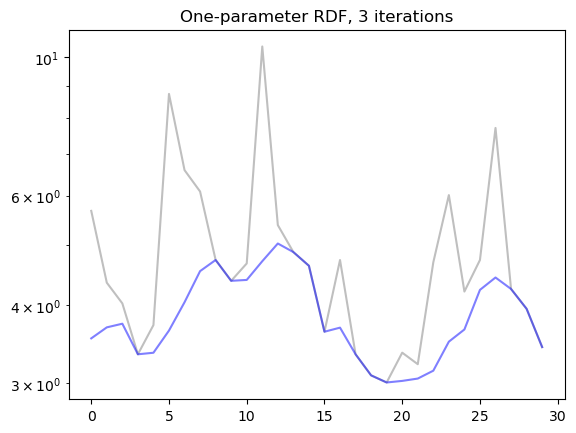

In [7]:
# After n iterations
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
ax1.plot(Q, color='gray', alpha=0.5)
ax1.plot(Qb, color='blue', alpha=0.5)
ax1.set_title('One-parameter RDF, {} iterations'.format(n))
plt.show()

## Base Flow Index (BFI) of Wahl and Wahl, 1995

https://www.usbr.gov/tsc/techreferences/hydraulics_lab/pubs/PAP/PAP-0708.pdf

### Using Numpy and Scipy

In [8]:
# calculate the mean discharge minima for each n-day block
def get_window_mins(arr, step):
    window_starts = np.arange(floor(len(arr) / step)) * step
    for start in window_starts:
        yield start + arr[start:start+step].argmin()

N = 3
window_min_ix = list(get_window_mins(Q, N))
window_min_vals = np.take(Q, window_min_ix)

In [9]:
# set the factor
f = 0.9

# make a boolean mask with turning points == True
mask = np.where(
    (f*window_min_vals < np.roll(window_min_vals, 1)) & (f*window_min_vals < np.roll(window_min_vals, -1)),
    True, False
) 

In [10]:
# filter the turning point indices from the minima indices 
turning_pt_ix = np.delete(window_min_ix, ~mask)

In [11]:
from scipy.interpolate import interp1d

# interpolate within our range of index values
fn = interp1d(turning_pt_ix, Q.take(turning_pt_ix), kind='linear')
X = np.arange(turning_pt_ix.min(), turning_pt_ix.max())
Y = fn(X)

# within the interpolated range set any Y > Q equal to Q
Y = np.where((Y > Q[X]), Q[X], Y)


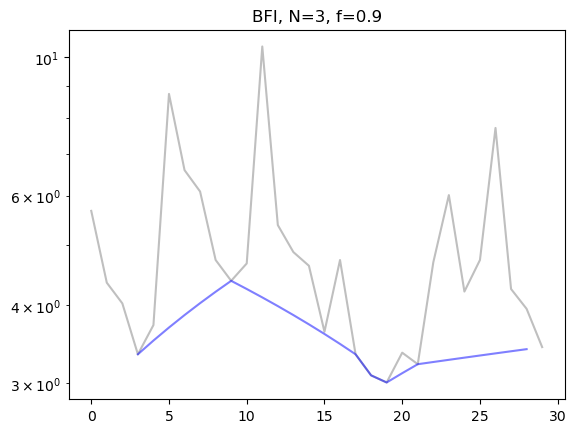

In [12]:
# Plot BFI
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
ax1.plot(Q, color='gray', alpha=0.5)
ax1.plot(X, Y, color='blue', alpha=0.5)
ax1.set_title('BFI, N={}, f={}'.format(N, f))
plt.show()

### Using Pandas

In [13]:
# do a more panda-centric approach


## Two-Parameter Recursive Digital Filter of Eckhardt, 2005



$\large Q_{b_{t}} = \Large \frac{(1 - \beta) \cdot \alpha \cdot Q_{b_{(t- \Delta t)}} + (1 - \alpha ) \cdot \beta \cdot Q_{t}}{1 - \alpha \cdot \beta}$

where:

- $\alpha$ is a dimensionless recession constant between 0 and 1
- $\beta$ is a long-term ratio of baseflow to total streamflow between 0 and 1, and is equivalent to $BFI_{max}$
- $Q_{t}$ is observed discharge at time t
- $Q_{\beta_{t}}$ is calculated baseflow dischage at time t
- $Q_{\beta_{(t- \Delta t)}}$ is calculated baseflow dischage at time t-1 sampling interval

In [14]:
alpha = 0.98   # filter parameter alpha
beta = 0.6    # filter parameter beta
Qb = Q         # initialize baseflow to Q

In [15]:
n = 1

for i in range(n):
    Qb = ((1 - beta) * alpha * np.roll(Qb, 1) + (1-alpha)*beta*Q) / (1-alpha*beta)    
    Qb = np.where((Qb > Q), Q, Qb)    

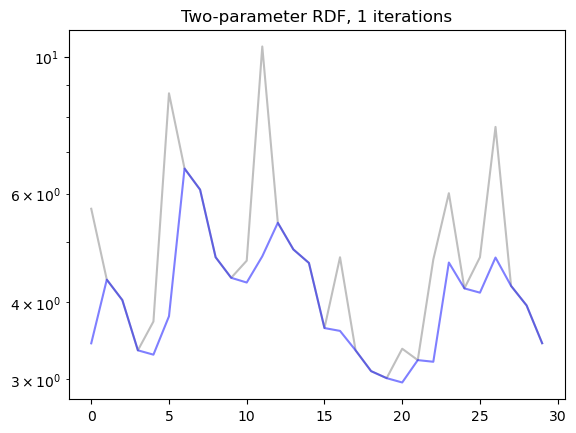

In [16]:
# After n iterations
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_yscale('log')
ax1.plot(Q, color='gray', alpha=0.5)
ax1.plot(Qb, color='blue', alpha=0.5)
ax1.set_title('Two-parameter RDF, {} iterations'.format(n))
plt.show()

## References:

[Introduction to Digital Filters](https://123.physics.ucdavis.edu/week_5_files/filters/digital_filter.pdf)
- A physics lesson on digital filters for signal processing.
- Recursive filters are also refered to as IIR (Infinite Impulse Response) Filters. Scipy has signal modules that may be used to build such filters.

[Optimal hydrograph separation using a recursive digital filter constrained by chemical mass balance, with application to selected Chesapeake Bay watersheds](https://pubs.er.usgs.gov/publication/sir20175034)
- Raffensperger et al, 2017 
- Evaluates baseflow separation calculations in Chesapeake Bay tributaries.

[HYSEP: A COMPUTER PROGRAM FOR STREAMFLOW HYDROGRAPH SEPARATION AND ANALYSIS](https://water.usgs.gov/software/HYSEP/code/doc/hysep.pdf)
- Sloto and Crouse, 1996

[Beyond binary baseflow separation: a delayed-flow index for multiple streamflow contributions](https://hess.copernicus.org/articles/24/849/2020/)
- Stoelze, et al, 2020
- Discusses delayed flow hydrographs. The baseflow that a given method returns may consist of multiple delayed flows (long-term groundwater, short-term groundwater, showmelt...). Furthermore the estimation of the BFI ratio is subject to some vagaries that depend on the size of the block, N, used to extract minima or turning points. 
